In [170]:
import keras
import nb_utils
import numpy as np

In [2]:
squad_training = json.load(
    open(nb_utils.download('https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json'))
)

## Converting our training data

The squad training data is structured as a list of paragraphs, each with an associated set of questions.  Let's preprocess this a bit before we continue

In [3]:
squad_training['data'][1]

{'paragraphs': [{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
   'qas': [{'answers': [{'answer_start': 269, 'text': 'in the late 1990s'}],
     'id': '56be85543aeaaa14008c9063',
     'question': 'When did Beyonce start becoming popular?'},
    {'answers': [{'answer_start': 207, 'text': 'singing and dancing'}],
     'id': '56be85543

In [4]:
from keras.preprocessing.text import Tokenizer

VOCAB_SIZE = 250000
tokenizer = Tokenizer(num_words=VOCAB_SIZE)

In [5]:
all_text = []

for article in squad_training['data']:
    for p in article['paragraphs']:
        all_text.append(p['context'])
        for qa in p['qas']:
            all_text.append(qa['question'])
            
tokenizer.fit_on_texts(all_text)

In [192]:
question_tokens = []
answer_locations = []
context_tokens = []

for article in squad_training['data']:
    for p in article['paragraphs']:
        ct = tokenizer.texts_to_sequences([p['context']])[0]

        for qa in p['qas']:
            qt = tokenizer.texts_to_sequences([qa['question']])[0]
            at = tokenizer.texts_to_sequences([qa['answers'][0]['text']])[0]
            for j in range(len(ct) - len(at)):
                if ct[j:j+len(at)] == at:
                    question_tokens.append(qt)
                    answer_locations.append((j, j + len(a)))
                    context_tokens.append(ct)
                    break

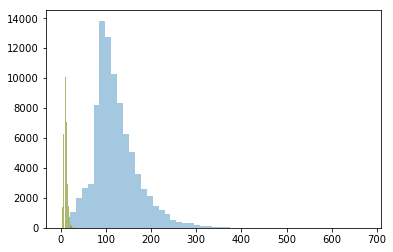

In [7]:
%matplotlib inline
import seaborn
[
    seaborn.distplot([len(s) for s in context_tokens], kde=False),
    seaborn.distplot([len(s) for s in question_tokens], kde=False),
    seaborn.distplot([len(s) for s in answer_tokens], kde=False),
]

In [220]:
import random
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

def training_generator(bs=2):
    while True:
        batch_q = []
        batch_c = []
        start_idx = []
        end_idx = []

        idx = np.random.randint(0, len(context_tokens) - 1, size=bs)
        for i in idx:
            batch_q.append(question_tokens[i])
            batch_c.append(context_tokens[i])
            start_idx.append(answer_locations[i][0])
            end_idx.append(answer_locations[i][1])
        
        batch_q = pad_sequences(batch_q)
        batch_c = pad_sequences(batch_c)
        onehot_start = np.zeros_like(batch_c)
        onehot_end = np.zeros_like(batch_c)
        onehot_start[np.arange(len(start_idx)), start_idx] = 1
        onehot_end[np.arange(len(start_idx)), end_idx] = 1
        
        yield ({
            'question': batch_q,
            'context': batch_c,
        }, {
            'start_idx': onehot_start,
            'end_idx': onehot_end,
        })

        
tg = training_generator(5)
for i in range(10):
    x = next(tg)

In [224]:
import tensorflow as tf
from keras.layers.merge import concatenate
from keras import layers, models
from keras.layers import Bidirectional, LSTM
import keras.backend as K

HIDDEN_SIZE = 50
EMBEDDING_SIZE = 50

def model(weights):
    question = layers.Input(name='question', dtype='int32', shape=(None,))
    context = layers.Input(name='context', dtype='int32', shape=(None,))
    
    embedding = layers.Embedding(
        mask_zero=True,
        input_dim=min(len(tokenizer.word_index), VOCAB_SIZE),
        output_dim=EMBEDDING_SIZE,
    )
    
    # Keras/Tensorflow doesn't have a builtin for outer products.  We
    # can abuse how broadcasting works to accomplish it, by adding 
    # empty extra dimensions in the right places.
    def outer_product(x, y):
        batch_size = K.shape(x)[0]
        w = K.shape(x)[1]
        h = K.shape(y)[1]
        outer_product = K.batch_dot(x, y, axes=(2,2))
        print(K.int_shape(outer_product))
#         outer_product = K.reshape(outer_product, (batch_size, w, h))
        return outer_product
    
    def context2query(inputs):
        question, context = inputs
        op = outer_product(question, context)
        e = K.exp(op - K.max(op, axis=2, keepdims=True))
        s = K.sum(op, axis=2, keepdims=True)
        softmax = e / s
        
        question = K.expand_dims(question, axis=2)
        attention = K.expand_dims(softmax, axis=-1) * question
        return K.sum(attention, axis=1)

    def query2context(inputs):
        question, context = inputs
        op = outer_product(question, context)
        attention = K.softmax(K.max(op, axis=1))
        return context * K.expand_dims(attention, axis=-1)

    encoded_question = Bidirectional(LSTM(units=HIDDEN_SIZE, return_sequences=True), merge_mode='concat')(embedding(question))
    encoded_context = Bidirectional(LSTM(units=HIDDEN_SIZE, return_sequences=True), merge_mode='concat')(embedding(context))

    # Take the softmax over the question, and sum the encoded contexts:
    c2q = layers.Lambda(context2query)([encoded_question, encoded_context])
    q2c = layers.Lambda(query2context)([encoded_question, encoded_context])
    G = concatenate([encoded_context, 
                      c2q, 
                      layers.Multiply()([c2q, encoded_context]),
                      layers.Multiply()([q2c, encoded_context]),
                     ])

    def flat_softmax(inputs):
        return K.softmax(K.batch_flatten(inputs))
    
    M = Bidirectional(LSTM(units=HIDDEN_SIZE, return_sequences=True), merge_mode='concat')(G)
    start_idx = layers.TimeDistributed(layers.Dense(units=1))(concatenate([M, G]))
    start_idx = layers.Lambda(flat_softmax, name='start_idx')(start_idx)
    
    M2 = Bidirectional(LSTM(units=HIDDEN_SIZE, return_sequences=True), merge_mode='concat')(M)
    end_idx = layers.TimeDistributed(layers.Dense(units=1))(concatenate([M2, G]))
    end_idx = layers.Lambda(flat_softmax, name='end_idx')(end_idx)
    model = models.Model(inputs=[question, context],
                        outputs=[start_idx, end_idx])
    
    def idx_loss(y_true, y_pred):
        "Negative log loss for the true index.  y_true must be passed in as a one-hot vector."
        return K.categorical_crossentropy(y_pred, y_true)
    
    model.compile(
        metrics=['accuracy'],
        optimizer='adam',
        loss={'start_idx': 'categorical_crossentropy', 'end_idx': 'categorical_crossentropy'},
    )
    return model
    
    
m = model(weights=None)
m.summary()

(None, None, None)
(None, None, None)
(None, None, None)
(None, None, None)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
context (InputLayer)             (None, None)          0                                            
____________________________________________________________________________________________________
question (InputLayer)            (None, None)          0                                            
____________________________________________________________________________________________________
embedding_127 (Embedding)        (None, None, 50)      4594450     question[0][0]                   
                                                                   context[0][0]                    
____________________________________________________________________________________________________
lstm_316 (LSTM)

In [225]:
m.fit_generator(training_generator(bs=1), steps_per_epoch=1000, epochs=10)

Epoch 1/10
  40/1000 [>.............................] - ETA: 1386s - loss: 9.5923 - start_idx_loss: 4.7993 - end_idx_loss: 4.7929 - start_idx_acc: 0.0000e+00 - end_idx_acc: 0.0250

KeyboardInterrupt: 